### Test how good is the detection
1. Get all dataset descriptions that have the have the dataset_description_unknown (the language is unknown)
2. Classify the descriptions
3. Compare the classified language with the dataset_language

In [1]:
import psycopg2
import json
import pandas as pd

try:
    del df

except NameError:
    pass

config_file = r"C:\FHNW_lokal\6000\4M\01_ETL\21_load\db_config.json"

def load_config(config_path=config_file):
    with open(config_path) as f:
        return json.load(f)

query = """
SELECT dataset_identifier, dataset_language, dataset_description_UNKNOWN
FROM merged_dataset_metadata
WHERE dataset_title_UNKNOWN IS NOT NULL
  AND dataset_title_DE IS NULL
  AND dataset_title_EN IS NULL
  AND dataset_title_IT IS NULL
  AND dataset_title_FR IS NULL
  AND dataset_description_UNKNOWN IS NOT NULL
ORDER BY dataset_description_UNKNOWN DESC;
"""

# Load config and connect
config = load_config()

try:
    conn = psycopg2.connect(
        database="4M",
        user=config["user"],
        password=config["password"],
        host=config["host"],
        port=config["port"]
    )
    cur = conn.cursor()
    cur.execute(query)
    
    # Get column names from cursor description
    colnames = [desc[0] for desc in cur.description]
    
    # Create DataFrame from fetched data
    df = pd.DataFrame(cur.fetchall(), columns=colnames)

    cur.close()
    conn.close()

except Exception as e:
    print("Error fetching metadata details:", e)


In [2]:
df.head()

,dataset_identifier,dataset_language,dataset_description_unknown
0,484d6313-2cb6-f140-b24d-ae2c0374f671,None,Zwischen 2000 bis 2002 analysierte die Fachste...
1,geoportal-36-3,['de'],Zuteilung der Stromnetzgebiete im Kanton St.Ga...
2,geoportal-36-2,['de'],Zuteilung der Stromnetzgebiete im Kanton St.Ga...
3,d4b2d1c6-e96b-7331-2f0f-6fde9c466596,None,"Zuständigkeitsgebiete der Notariate, Grundbuch..."
4,ur-1884,None,Zuständigkeitsgebiete der Gerichte im Kanton Uri


In [3]:
from langdetect import detect_langs
import pandas as pd

# Updated function to get top 2 languages
def detect_top_languages(text):
    try:
        langs = detect_langs(text)
        # Convert to list of (lang, prob) tuples
        results = [(l.lang, l.prob) for l in langs[:2]]  # Top 2
        # Pad with default values if fewer than 2 detected
        while len(results) < 2:
            results.append(('not_found', 0.0))
        return [[results[0][0]], results[0][1], [results[1][0]], results[1][1]]
    except:
        return [['not_found'], 0.0, ['not_found'], 0.0]

# Apply to DataFrame
df[["detected_language_1", "confidence_1", "detected_language_2", "confidence_2"]] = df[
    "dataset_description_unknown"
].apply(lambda x: pd.Series(detect_top_languages(x)))

# Preview
print(df[[
    "dataset_identifier", "dataset_language",
    "detected_language_1", "confidence_1",
    "detected_language_2", "confidence_2"
]].head())


                     dataset_identifier dataset_language detected_language_1  \
0  484d6313-2cb6-f140-b24d-ae2c0374f671             None                [de]   
1                        geoportal-36-3           ['de']                [de]   
2                        geoportal-36-2           ['de']                [de]   
3  d4b2d1c6-e96b-7331-2f0f-6fde9c466596             None                [de]   
4                               ur-1884             None                [de]   

   confidence_1 detected_language_2  confidence_2  
0      0.999997         [not_found]           0.0  
1      0.999997         [not_found]           0.0  
2      0.999997         [not_found]           0.0  
3      0.999997         [not_found]           0.0  
4      0.999995         [not_found]           0.0  


In [5]:
import ast
import pandas as pd

# Helper to safely convert strings to lists
def to_list(val):
    if pd.isna(val):
        return []
    if isinstance(val, list):
        return val
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return [val]

# Normalize both columns
df['dataset_language_list'] = df['detected_language_1'].apply(to_list)
df['detected_language_list'] = df['detected_language_1'].apply(to_list)

# Check if any dataset language is found in the detected language list
def has_overlap(row):
    # If dataset_language is missing, we cannot compare -> mark as NaN
    if not row['dataset_language_list']:
        return pd.NA
    if not row['detected_language_list']:
        return False
    return any(lang in row['detected_language_list'] for lang in row['dataset_language_list'])


# Apply search logic
df['language_match'] = df.apply(has_overlap, axis=1)

# Show result
print(df.head())


                     dataset_identifier dataset_language  \
0  484d6313-2cb6-f140-b24d-ae2c0374f671             None   
1                        geoportal-36-3           ['de']   
2                        geoportal-36-2           ['de']   
3  d4b2d1c6-e96b-7331-2f0f-6fde9c466596             None   
4                               ur-1884             None   

                         dataset_description_unknown detected_language_1  \
0  Zwischen 2000 bis 2002 analysierte die Fachste...                [de]   
1  Zuteilung der Stromnetzgebiete im Kanton St.Ga...                [de]   
2  Zuteilung der Stromnetzgebiete im Kanton St.Ga...                [de]   
3  Zuständigkeitsgebiete der Notariate, Grundbuch...                [de]   
4   Zuständigkeitsgebiete der Gerichte im Kanton Uri                [de]   

   confidence_1 detected_language_2  confidence_2 dataset_language_list  \
0      0.999997         [not_found]           0.0                  [de]   
1      0.999997         [not_fou

In [6]:
df['language_match'] = df.apply(has_overlap, axis=1)


In [7]:
# Filter mismatches
mismatches = df[df['language_match'] == False]

# Count mismatches by dataset_language
by_dataset_language = (
    mismatches.explode('dataset_language_list')
              .groupby('dataset_language_list')
              .size()
              .rename('mismatch_count')
              .reset_index()
              .sort_values(by='mismatch_count', ascending=False)
)

# Count mismatches by detected_language
by_detected_language = (
    mismatches.explode('detected_language_list')
              .groupby('detected_language_list')
              .size()
              .rename('mismatch_count')
              .reset_index()
              .sort_values(by='mismatch_count', ascending=False)
)

stats = {
    'language_match': len(mismatches),
    'by_dataset_language': by_dataset_language,
    'by_detected_language': by_detected_language
}


In [8]:
print("Mismatches by dataset language:")
print(by_dataset_language)

print("\nMismatches by detected language:")
print(by_detected_language)




Mismatches by dataset language:
Empty DataFrame
Columns: [dataset_language_list, mismatch_count]
Index: []

Mismatches by detected language:
Empty DataFrame
Columns: [detected_language_list, mismatch_count]
Index: []


In [9]:
# Convert detected_language to list if necessary
def to_list(val):
    if isinstance(val, list):
        return val
    try:
        return ast.literal_eval(val)
    except:
        return [val]

df['detected_language_list'] = df['detected_language'].apply(to_list)

# Identify classification status
df['classification_status'] = df['detected_language_list'].apply(
    lambda langs: 'unclassified' if langs == ['not_found'] else 'classified'
)

# Count totals
classification_counts = df['classification_status'].value_counts().reset_index()
classification_counts.columns = ['status', 'count']


KeyError: 'detected_language'

In [ ]:
import pandas as pd
import ast


# Normalize list columns
def to_list(val):
    if pd.isna(val):
        return []
    if isinstance(val, list):
        return val
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return [val]

df['dataset_language_list'] = df['dataset_language'].apply(to_list)
df['detected_language_list'] = df['detected_language'].apply(to_list)

# Detect language mismatches
df['language_match'] = df.apply(
    lambda row: pd.NA if not row['dataset_language_list']
    else any(lang in row['detected_language_list'] for lang in row['dataset_language_list']),
    axis=1
)

# Filter mismatches
mismatches = df[df['language_match'] == False][[
    'dataset_identifier', 'dataset_description_unknown',
    'dataset_language',  "detected_language_1", "confidence_1",
    "detected_language_2", "confidence_2"
]]

# Display as a beautiful table (works in Jupyter or supported environments)
from IPython.display import display
display(mismatches)
# Save mismatches to CSV
mismatches.to_csv(r"C:\Users\fabia\OneDrive - FHNW\03_FHNW\06_6_Semester\03_6000_BTh\91_NLP Unterlagen\language_detection\second_language.csv", index=False)


,dataset_identifier,dataset_description_unknown,dataset_language,detected_language_1,confidence_1,detected_language_2,confidence_2
65,geoportal-881-4400,Werkplan Abwasser TG12,['de'],[nl],0.713975,[de],0.285714
67,geoportal-881-4056,Werkplan Abwasser TG12,['de'],[nl],0.714284,[de],0.285714
69,geoportal-881-4053,Werkplan Abwasser TG12,['de'],[de],0.571425,[nl],0.428119
72,geoportal-881-45,Werkplan Abwasser TG12,['de'],[de],0.714281,[nl],0.285715
78,geoportal-881-4014,Werkplan Abwasser TG12,['de'],[nl],0.571427,[de],0.428570
83,geoportal-881-4718,Werkplan Abwasser TG12,['de'],[de],0.571427,[nl],0.285715
95,geoportal-95-2,Waldstandortskartierung,['de'],[sv],0.999995,[not_found],0.000000
96,geoportal-95-3,Waldstandortskartierung,['de'],[sv],0.999994,[not_found],0.000000
220,e736d23b-57f7-4ba8-b4a4-18587a182251,Standorte Recyclinghof,['de'],[en],0.999996,[not_found],0.000000
255,da5e023d-dae1-4dd5-8195-bb9a43e1f4a6,Standorte Cargo- und E-Tram,['de'],[es],0.857141,[pt],0.142859


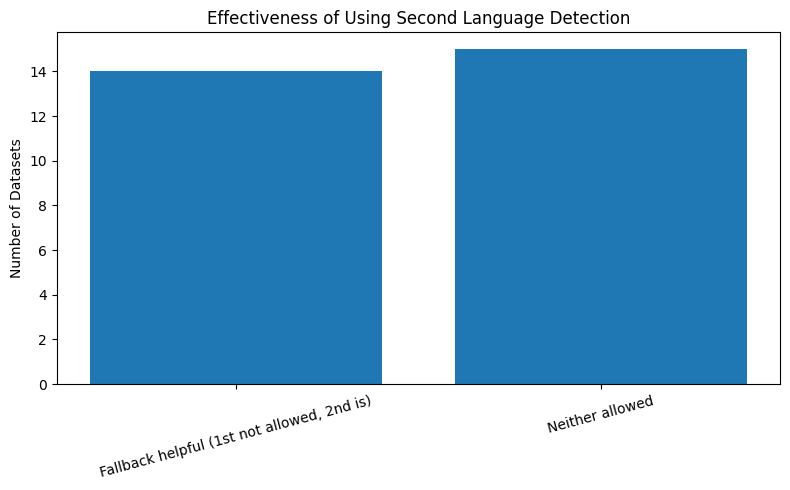

In [ ]:
import matplotlib.pyplot as plt

# Define allowed languages
allowed_languages = {'de', 'fr', 'en', 'it'}

def first_item(val):
    return val[0] if isinstance(val, list) and len(val) > 0 else 'not_found'


df['detected_language_1_clean'] = df['detected_language_1'].apply(first_item)
df['detected_language_2_clean'] = df['detected_language_2'].apply(first_item)

# Create flags
df['primary_allowed'] = df['detected_language_1_clean'].isin(allowed_languages)
df['secondary_allowed'] = df['detected_language_2_clean'].isin(allowed_languages)

# Focus on rows where the first is NOT allowed but the second IS
df['fallback_helpful'] = (~df['primary_allowed']) & (df['secondary_allowed'])

# Count relevant categories for visualization
counts = {
    # "Primary allowed": df['primary_allowed'].sum(),
    "Fallback helpful (1st not allowed, 2nd is)": df['fallback_helpful'].sum(),
    "Neither allowed": ((~df['primary_allowed']) & (~df['secondary_allowed'])).sum()
}

# Plot
plt.figure(figsize=(8, 5))
plt.bar(counts.keys(), counts.values())
plt.ylabel("Number of Datasets")
plt.title("Effectiveness of Using Second Language Detection")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


Total rows: 4678
Non-empty dataset_language: 3466
language_match == True: 3398 (98.0%)
language_match == False: 68 (2.0%)
language_match is empty (NaN): 1212 (25.9%)
Total rows: 4678
Non-empty dataset_language: 3466
language_match == True: 3398
language_match == False: 68
language_match is empty (NaN): 1212


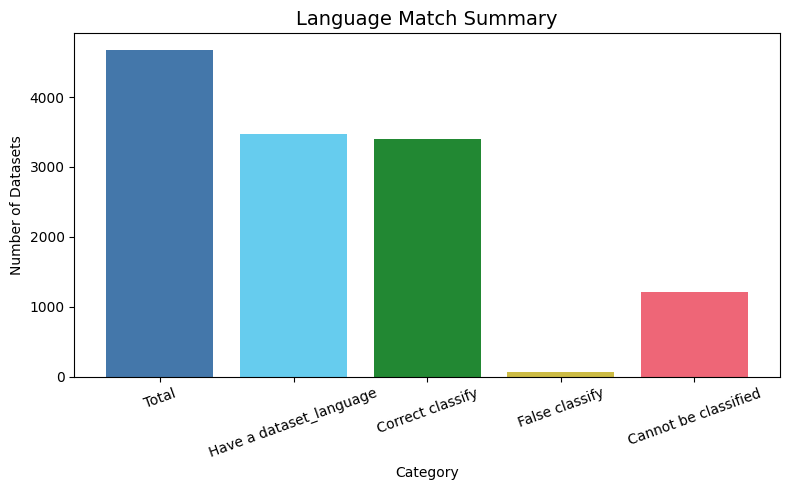

In [17]:
import pandas as pd
import ast
import matplotlib.pyplot as plt


# Convert detected_language to list if needed
def to_list(val):
    if isinstance(val, list):
        return val
    try:
        return ast.literal_eval(val)
    except:
        return [val]

df['detected_language_list'] = df['detected_language_1'].apply(to_list)

# Detect classification status
df['classification_status'] = df['detected_language_list'].apply(
    lambda langs: 'unclassified' if langs == ['not_found'] else 'classified'
)

# Count stats
total_rows = df['dataset_identifier'].notna().sum()
non_empty_dataset_language = df['dataset_language'].notna().sum()

# Compute language match
def match_language(row):
    try:
        dataset_lang = ast.literal_eval(row['dataset_language']) if pd.notna(row['dataset_language']) else []
        detected_lang = to_list(row['detected_language_1'])
        if not dataset_lang:
            return pd.NA
        return any(lang in detected_lang for lang in dataset_lang)
    except:
        return pd.NA

df['language_match'] = df.apply(match_language, axis=1)

# Count match results
true_matches = (df['language_match'] == True).sum()
false_matches = (df['language_match'] == False).sum()
empty_matches = df['language_match'].isna().sum()

# Print summary with percentages
print("Total rows:", total_rows)
print("Non-empty dataset_language:", non_empty_dataset_language)
print(f"language_match == True: {true_matches} ({true_matches/non_empty_dataset_language:.1%})")
print(f"language_match == False: {false_matches} ({false_matches/non_empty_dataset_language:.1%})")
print(f"language_match is empty (NaN): {empty_matches} ({empty_matches/total_rows:.1%})")

# Visualization
match_counts = {
    'True': true_matches,
    'False': false_matches,
    'Empty': empty_matches
}

# Print summary
print("Total rows:", total_rows)
print("Non-empty dataset_language:", non_empty_dataset_language)
print("language_match == True:", true_matches)
print("language_match == False:", false_matches)
print("language_match is empty (NaN):", empty_matches)

import matplotlib.pyplot as plt

# Updated color palette: Colorblind-friendly (Paul Tol’s “bright” palette)
colors = ['#4477AA', '#66CCEE', '#228833', '#CCBB44', '#EE6677']

# Bar chart values
match_counts = {
    'Total': total_rows,
    'Have a dataset_language': non_empty_dataset_language,
    'Correct classify': true_matches,
    'False classify': false_matches,
    'Cannot be classified': empty_matches
}

# Create bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(match_counts.keys(), match_counts.values(), color=colors)
plt.title("Language Match Summary", fontsize=14)
plt.ylabel("Number of Datasets")
plt.xlabel("Category")
plt.xticks(rotation=20)


plt.tight_layout()
plt.show()



### Productive Code
1. Get all Data, that dosen't have a language
2. Classify the description
3. Map description, title and keywords into to correct language

In [1]:
import psycopg2
import json
import pandas as pd

try:
    del df

except NameError:
    pass

config_file = r"C:\FHNW_lokal\6000\4M\01_ETL\21_load\db_config.json"

def load_config(config_path=config_file):
    with open(config_path) as f:
        return json.load(f)

query = """
SELECT dataset_identifier, dataset_title_UNKNOWN, dataset_description_UNKNOWN, dataset_keyword_UNKNOWN
FROM merged_dataset_metadata
WHERE dataset_title_UNKNOWN IS NOT NULL
  AND dataset_title_DE IS NULL
  AND dataset_title_EN IS NULL
  AND dataset_title_IT IS NULL
  AND dataset_title_FR IS NULL
  AND dataset_description_UNKNOWN IS NOT NULL
  AND dataset_language IS NULL
ORDER BY dataset_description_UNKNOWN DESC;
"""

# Load config and connect
config = load_config()

try:
    conn = psycopg2.connect(
        database="4M_copy",
        user=config["user"],
        password=config["password"],
        host=config["host"],
        port=config["port"]
    )
    cur = conn.cursor()
    cur.execute(query)
    
    # Get column names from cursor description
    colnames = [desc[0] for desc in cur.description]
    
    # Create DataFrame from fetched data
    df = pd.DataFrame(cur.fetchall(), columns=colnames)

    cur.close()
    conn.close()

except Exception as e:
    print("Error fetching metadata details:", e)

df.head()


,dataset_identifier,dataset_title_unknown,dataset_description_unknown,dataset_keyword_unknown
0,484d6313-2cb6-f140-b24d-ae2c0374f671,Modellierte Potenziale für naturnahe Lebensräume,Zwischen 2000 bis 2002 analysierte die Fachste...,"['opendata.swiss', 'Lebensraumpotenzial', 'Feu..."
1,d4b2d1c6-e96b-7331-2f0f-6fde9c466596,"Notariats-, Grundbuch- und Konkursamtskreise","Zuständigkeitsgebiete der Notariate, Grundbuch...","['opendata.swiss', 'notariate', 'notariatskrei..."
2,ur-1884,Gerichtsbezirke,Zuständigkeitsgebiete der Gerichte im Kanton Uri,"['Geobasisdaten', 'opendata.swiss']"
3,58acaf19-4048-4192-829c-a7decd4a0cec,Risikokataster,Zur übersichtlichen Darstellung der Gefahren u...,"['Störfallvorsorge', 'Störfall', 'opendata.swi..."
4,ur-1731,Forstkreise und Forstreviere,Zu den Forstkreisen gehören mehrere Forstrevie...,"['Forstkreis', 'Forstrevier', 'Geobasisdaten',..."


In [2]:
from langdetect import detect_langs

ALLOWED_LANGUAGES = {'de', 'en', 'fr', 'it'}

# Detect top language from allowed list
def detect_preferred_language(text):
    try:
        langs = detect_langs(text)
        for lang in langs[:2]:
            if lang.lang in ALLOWED_LANGUAGES:
                return [[lang.lang], lang.prob]
        return [['not_found'], 0.0]
    except:
        return [['not_found'], 0.0]

# Apply detection to your description column
df[['detected_language', 'language_confidence']] = df['dataset_description_unknown'].apply(
    lambda x: pd.Series(detect_preferred_language(x))
)

df.head()


,dataset_identifier,dataset_title_unknown,dataset_description_unknown,dataset_keyword_unknown,detected_language,language_confidence
0,484d6313-2cb6-f140-b24d-ae2c0374f671,Modellierte Potenziale für naturnahe Lebensräume,Zwischen 2000 bis 2002 analysierte die Fachste...,"['opendata.swiss', 'Lebensraumpotenzial', 'Feu...",[de],0.999994
1,d4b2d1c6-e96b-7331-2f0f-6fde9c466596,"Notariats-, Grundbuch- und Konkursamtskreise","Zuständigkeitsgebiete der Notariate, Grundbuch...","['opendata.swiss', 'notariate', 'notariatskrei...",[de],0.999997
2,ur-1884,Gerichtsbezirke,Zuständigkeitsgebiete der Gerichte im Kanton Uri,"['Geobasisdaten', 'opendata.swiss']",[de],0.999996
3,58acaf19-4048-4192-829c-a7decd4a0cec,Risikokataster,Zur übersichtlichen Darstellung der Gefahren u...,"['Störfallvorsorge', 'Störfall', 'opendata.swi...",[de],0.999995
4,ur-1731,Forstkreise und Forstreviere,Zu den Forstkreisen gehören mehrere Forstrevie...,"['Forstkreis', 'Forstrevier', 'Geobasisdaten',...",[de],0.999997


In [3]:
import psycopg2.extras
import pandas as pd

# Ensure detected_language is flattened and lowercased
df['detected_lang'] = df['detected_language'].apply(
    lambda x: x[0].lower() if isinstance(x, list) and len(x) > 0 else 'not_found'
)

# Language-specific column mappings (all lowercase)
lang_map = {
    'de': {
        'title_col': 'dataset_title_de',
        'keyword_col': 'dataset_keyword_de',
        'description_col': 'dataset_description_de'
    },
    'en': {
        'title_col': 'dataset_title_en',
        'keyword_col': 'dataset_keyword_en',
        'description_col': 'dataset_description_en'
    },
    'fr': {
        'title_col': 'dataset_title_fr',
        'keyword_col': 'dataset_keyword_fr',
        'description_col': 'dataset_description_fr'
    },
    'it': {
        'title_col': 'dataset_title_it',
        'keyword_col': 'dataset_keyword_it',
        'description_col': 'dataset_description_it'
    }
}

# Reconnect to DB and update in loop
try:
    conn = psycopg2.connect(
        database="4M_copy",
        user=config["user"],
        password=config["password"],
        host=config["host"],
        port=config["port"]
    )
    cur = conn.cursor()

    for _, row in df.iterrows():
        lang = row['detected_lang']
        mapping = lang_map.get(lang)

        if not mapping:
            continue  # Skip unknown or unsupported languages

        updates = []
        values = []

        # Track which unknowns to clear
        unknowns_to_clear = []

        # Title
        if pd.notna(row['dataset_title_unknown']):
            updates.append(f"{mapping['title_col']} = %s")
            values.append(row['dataset_title_unknown'])
            unknowns_to_clear.append("dataset_title_unknown")

        # Keyword
        if pd.notna(row['dataset_keyword_unknown']):
            updates.append(f"{mapping['keyword_col']} = %s")
            values.append(row['dataset_keyword_unknown'])
            unknowns_to_clear.append("dataset_keyword_unknown")

        # Description
        if mapping['description_col'] and pd.notna(row['dataset_description_unknown']):
            updates.append(f"{mapping['description_col']} = %s")
            values.append(row['dataset_description_unknown'])
            unknowns_to_clear.append("dataset_description_unknown")

        if not updates:
            continue  # Skip if nothing to update

        # Add unknown-clearing part
        for col in unknowns_to_clear:
            updates.append(f"{col} = NULL")

        update_query = f"""
            update merged_dataset_metadata
            set {', '.join(updates)}
            where dataset_identifier = %s
        """
        values.append(row['dataset_identifier'])

        cur.execute(update_query, values)

    conn.commit()
    cur.close()
    conn.close()
    print("Mapped and cleaned up unknown metadata successfully.")

except Exception as e:
    print("Error during metadata update:", e)


Mapped and cleaned up unknown metadata successfully.


### More generell solution:

In [11]:
import psycopg2
import pandas as pd
import json

# --- CONFIGURABLE ---
config_file = r"C:\FHNW_lokal\6000\4M\01_ETL\21_load\db_config.json"
dbname = "4M_copy"
table_name = "merged_dataset_metadata"

# --- FUNCTIONS ---
def load_config(config_path=config_file):
    with open(config_path) as f:
        return json.load(f)

# --- MAIN SCRIPT ---
config = load_config()
config["dbname"] = dbname

# Define language prefixes and base column names
language_prefixes = ["DE", "EN", "FR", "IT"]
base_columns = ["dataset_title", "dataset_keyword", "dataset_description"]

# Generate column names dynamically
columns_to_load = ["dataset_identifier"] + [f"{col}_{lang}" for lang in language_prefixes for col in base_columns]

try:
    conn = psycopg2.connect(**config)
    cur = conn.cursor()
    query = f"""
        SELECT {', '.join(columns_to_load)}
        FROM {table_name}
        LIMIT 1000
    """
    cur.execute(query)
    colnames = [desc[0] for desc in cur.description]
    df = pd.DataFrame(cur.fetchall(), columns=colnames)
    cur.close()
    conn.close()
except Exception as e:
    print("Error loading data:", e)
    df = pd.DataFrame()

# --- DISPLAY ---
if df.empty:
    print("No data loaded for processing.")
else:
    print(df)


### Change wrong langauge informations

In [6]:
import psycopg2
import pandas as pd
import json
import langid
langid.set_languages(['en', 'fr', 'de', 'it'])

# --- FUNCTIONS ---
def load_config(config_path):
    with open(config_path) as f:
        return json.load(f)

def generate_columns(identifier, base_cols, prefixes):
    language_columns = [f"{col}_{lang.lower()}" for lang in prefixes for col in base_cols]
    return [identifier] + language_columns

def process_language_status(df, prefixes):
    for lang in prefixes:
        title_col = f"dataset_title_{lang.lower()}"
        keyword_col = f"dataset_keyword_{lang.lower()}"
        desc_col = f"dataset_description_{lang.lower()}"
        status_col = f"language_status_{lang.lower()}"

        def check_status(row):
            if all(pd.isna(row[col]) or not str(row[col]).strip() for col in [title_col, keyword_col, desc_col]):
                return "no_data"
            if all((pd.isna(row[col]) or not str(row[col]).strip()) for col in [title_col, desc_col]) and pd.notna(row[keyword_col]) and str(row[keyword_col]).strip():
                return "only_keywords"
            return None

        df[status_col] = df.apply(check_status, axis=1)
    return df

def detect_preferred_language(text, language_prefixes):
    language_prefixes = [lang.lower() for lang in language_prefixes]
    try:
        lang, prob = langid.classify(str(text))
        if lang in language_prefixes:
            return lang, round(prob, 3)
        else:
            return ['not_found'], 0.0
    except:
        return ['not_found'], 0.0

def evaluate_text_lengths(df, language_prefixes, min_length_lang_detect):
    for lang in language_prefixes:
        lang = lang.lower()
        title_col = f"dataset_title_{lang}"
        desc_col = f"dataset_description_{lang}"
        flag_col = f"text_length_flag_{lang}"
        status_col = f"language_status_{lang}"

        def assess_length(row):
            title = str(row[title_col]) if pd.notna(row[title_col]) else ""
            desc = str(row[desc_col]) if pd.notna(row[desc_col]) else ""
            title_long = len(title.strip()) > min_length_lang_detect
            desc_long = len(desc.strip()) > min_length_lang_detect

            if title_long and desc_long:
                return "title_and_description_long"
            elif desc_long:
                return "description_long"
            elif title_long:
                return "title_long"
            else:
                return "neither_long"

        df[flag_col] = df.apply(assess_length, axis=1)

        def validate_language(row):
            if row[flag_col] == "neither_long":
                if any(pd.notna(row[col]) and str(row[col]).strip() for col in [title_col, desc_col]):
                    return "not_enough_information"
                return row.get(status_col, None)
            if row[flag_col] in ["title_and_description_long", "description_long", "title_long"]:
                text_parts = []
                if row[flag_col] in ["title_and_description_long", "title_long"]:
                    text_parts.append(str(row[title_col]))
                if row[flag_col] in ["title_and_description_long", "description_long"]:
                    text_parts.append(str(row[desc_col]))
                combined_text = " ".join(text_parts)
                detected_lang, detected_prob = detect_preferred_language(combined_text, language_prefixes)
                if detected_lang == lang:
                    return f"correct"
                else:
                    return f"incorrect_new_{detected_lang}"
            return row.get(status_col, None)

        df[status_col] = df.apply(validate_language, axis=1)

    return df

def relocate_incorrect_text(df, language_prefixes):
    for lang in language_prefixes:
        lang = lang.lower()
        status_col = f"language_status_{lang}"
        title_col = f"dataset_title_{lang}"
        desc_col = f"dataset_description_{lang}"

        for idx, row in df.iterrows():
            status = row[status_col]
            if status and status.startswith("incorrect_new_"):
                target_lang = status.replace("incorrect_new_", "")
                new_title_col = f"dataset_title_{target_lang}"
                new_desc_col = f"dataset_description_{target_lang}"

                if pd.isna(row.get(new_title_col)) or not str(row.get(new_title_col)).strip():
                    df.at[idx, new_title_col] = row[title_col]
                    df.at[idx, new_desc_col] = row[desc_col]

                df.at[idx, title_col] = None
                df.at[idx, desc_col] = None
    return df

def add_language_quality(df):
    df["language_quality"] = None
    return df

def set_language_quality(df, language_prefixes):
    def determine_quality(row):
        current_quality = row.get("language_quality", None)
        if current_quality == "identical_description":
            return current_quality
        for lang in language_prefixes:
            status = row.get(f"language_status_{lang.lower()}", "")
            if status and status.startswith("incorrect"):
                return "incorrect"
        return "correct"

    df["language_quality"] = df.apply(determine_quality, axis=1)
    return df

def check_identical_descriptions(df, prefixes):
    desc_cols = [f"dataset_description_{lang.lower()}" for lang in prefixes]

    def has_identical_descriptions(row):
        descriptions = [str(row[col]).strip().lower() for col in desc_cols if pd.notnull(row[col]) and str(row[col]).strip()]
        seen = {}
        for desc in descriptions:
            if desc in seen:
                return True
            seen[desc] = True
        return False

    df["language_quality"] = df.apply(
        lambda row: "identical_description" if has_identical_descriptions(row) else row.get("language_quality", None),
        axis=1
    )
    return df

def fetch_dataset_metadata(config_path, db_name, table, identifier, base_cols, prefixes):
    config = load_config(config_path)
    config["dbname"] = db_name
    columns_to_load = generate_columns(identifier, base_cols, prefixes)

    try:
        conn = psycopg2.connect(**config)
        cur = conn.cursor()
        query = f"""
            SELECT {', '.join(columns_to_load)}
            FROM {table}

        """
        cur.execute(query)
        colnames = [desc[0] for desc in cur.description]
        df = pd.DataFrame(cur.fetchall(), columns=colnames)
        cur.close()
        conn.close()
    except Exception as e:
        print("Error loading data:", e)
        df = pd.DataFrame(columns=columns_to_load)

    return df

def main(config_file, dbname, table_name, language_prefixes, base_columns, min_length_lang_detect):
    df = fetch_dataset_metadata(
        config_path=config_file,
        db_name=dbname,
        table=table_name,
        identifier="dataset_identifier",
        base_cols=base_columns,
        prefixes=language_prefixes
    )

    if df.empty:
        print("No data loaded for processing.")
    else:
        df = process_language_status(df, language_prefixes)
        df = add_language_quality(df)
        df = check_identical_descriptions(df, language_prefixes)
        df = evaluate_text_lengths(df, language_prefixes, min_length_lang_detect)
        df = relocate_incorrect_text(df, language_prefixes)
        df = set_language_quality(df, language_prefixes)

        print(df)
        return df

# --- EXECUTION ---
if __name__ == "__main__":
    config_file = r"C:\\FHNW_lokal\\6000\\4M\\01_ETL\\21_load\\db_config.json"
    dbname = "4M_copy"
    table_name = "merged_dataset_metadata"
    language_prefixes = ["DE", "EN", "FR", "IT"]
    base_columns = ["dataset_title", "dataset_keyword", "dataset_description"]
    min_length_lang_detect = 20

    df = main(config_file, dbname, table_name, language_prefixes, base_columns, min_length_lang_detect)


In [7]:
import psycopg2
import pandas as pd
import json
import langid
from tqdm import tqdm
langid.set_languages(['en', 'fr', 'de', 'it'])

# --- FUNCTIONS ---
def load_config(config_path):
    with open(config_path) as f:
        return json.load(f)

def generate_columns(identifier, base_cols, prefixes,table_type):
    language_columns = [f"{col}_{lang.lower()}" for lang in prefixes for col in base_cols]
    print(language_columns)
    return [identifier] + language_columns

def process_language_status(df, prefixes, table_set_type):
    EMPTY_VALUES = {"", "nan", "none", "null"}

    def is_empty(val):
        return pd.isna(val) or str(val).strip().lower() in EMPTY_VALUES

    for lang in prefixes:
        title_col = f"{table_set_type.lower()}_title_{lang.lower()}"
        keyword_col = f"{table_set_type.lower()}_keyword_{lang.lower()}"
        desc_col = f"{table_set_type.lower()}_description_{lang.lower()}"
        status_col = f"language_status_{lang.lower()}"

        def check_status(row):
            title_val = row.get(title_col)
            keyword_val = row.get(keyword_col)
            desc_val = row.get(desc_col)
            
            # Debug
            # print(f"[{lang}] title: {repr(title_val)}, keyword: {repr(keyword_val)}, desc: {repr(desc_val)}")

            if all(is_empty(val) for val in [title_val, keyword_val, desc_val]):
                return "no_data"

            if all(is_empty(val) for val in [title_val, desc_val]) and not is_empty(keyword_val):
                return "only_keywords"

            return None

        df[status_col] = df.apply(check_status, axis=1)

    return df



def detect_preferred_language(text, language_prefixes):
    language_prefixes = [lang.lower() for lang in language_prefixes]
    try:
        lang, prob = langid.classify(str(text))
        if lang in language_prefixes:
            return lang, round(prob, 3)
        else:
            return ['not_found'], 0.0
    except:
        return ['not_found'], 0.0

def evaluate_text_lengths(df, language_prefixes, min_length_lang_detect,table_set_type):
    for lang in language_prefixes:
        lang = lang.lower()
        title_col = f"{table_set_type.lower()}_title_{lang}"
        desc_col = f"{table_set_type.lower()}_description_{lang}"
        flag_col = f"text_length_flag_{lang}"
        status_col = f"language_status_{lang}"

        def assess_length(row):
            title = str(row[title_col]) if pd.notna(row[title_col]) else ""
            desc = str(row[desc_col]) if pd.notna(row[desc_col]) else ""
            title_long = len(title.strip()) > min_length_lang_detect
            desc_long = len(desc.strip()) > min_length_lang_detect

            if title_long and desc_long:
                return "title_and_description_long"
            elif desc_long:
                return "description_long"
            elif title_long:
                return "title_long"
            else:
                return "neither_long"

        df[flag_col] = df.apply(assess_length, axis=1)

        def validate_language(row):
            if row[flag_col] == "neither_long":
                if any(pd.notna(row[col]) and str(row[col]).strip() for col in [title_col, desc_col]):
                    return "not_enough_information"
                return row.get(status_col, None)
            if row[flag_col] in ["title_and_description_long", "description_long", "title_long"]:
                text_parts = []
                if row[flag_col] in ["title_and_description_long", "title_long"]:
                    text_parts.append(str(row[title_col]))
                if row[flag_col] in ["title_and_description_long", "description_long"]:
                    text_parts.append(str(row[desc_col]))
                combined_text = " ".join(text_parts)
                detected_lang, detected_prob = detect_preferred_language(combined_text, language_prefixes)
                if detected_lang == lang:
                    return f"correct"
                else:
                    return f"incorrect_new_{detected_lang}"
            return row.get(status_col, None)

        df[status_col] = df.apply(validate_language, axis=1)

    return df

def relocate_incorrect_text(df, language_prefixes,table_set_type):
    for lang in language_prefixes:
        lang = lang.lower()
        status_col = f"language_status_{lang.lower()}"
        title_col = f"{table_set_type.lower()}_title_{lang.lower()}"
        desc_col = f"{table_set_type.lower()}_description_{lang.lower()}"

        for idx, row in df.iterrows():
            status = row[status_col]
            if status and status.startswith("incorrect_new_"):
                target_lang = status.replace("incorrect_new_", "")
                new_title_col = f"{table_set_type.lower()}_title_{target_lang}"
                new_desc_col = f"{table_set_type.lower()}_description_{target_lang}"

                if pd.isna(row.get(new_title_col)) or not str(row.get(new_title_col)).strip():
                    df.at[idx, new_title_col] = row[title_col]
                    df.at[idx, new_desc_col] = row[desc_col]

                df.at[idx, title_col] = None
                df.at[idx, desc_col] = None
    return df

def add_language_quality(df):
    df["language_quality"] = None
    return df

def set_language_quality(df, language_prefixes):
    def determine_quality(row):
        current_quality = row.get("language_quality", None)
        if current_quality == "identical_description":
            return current_quality
        for lang in language_prefixes:
            status = row.get(f"language_status_{lang.lower()}", "")
            if status and status.startswith("incorrect"):
                return "incorrect"
        return "correct"

    df["language_quality"] = df.apply(determine_quality, axis=1)
    return df

def check_identical_descriptions(df, prefixes,table_set_type):
    desc_cols = [f"{table_set_type.lower()}_description_{lang.lower()}" for lang in prefixes]

    def has_identical_descriptions(row):
        descriptions = [str(row[col]).strip().lower() for col in desc_cols if pd.notnull(row[col]) and str(row[col]).strip()]
        seen = {}
        for desc in descriptions:
            if desc in seen:
                return True
            seen[desc] = True
        return False

    df["language_quality"] = df.apply(
        lambda row: "identical_description" if has_identical_descriptions(row) else row.get("language_quality", None),
        axis=1
    )
    return df

def fetch_dataset_metadata(config_path, db_name, table, identifier, base_cols, prefixes,table_type):
    config = load_config(config_path)
    config["dbname"] = db_name
    columns_to_load = generate_columns(identifier, base_cols, prefixes,table_set_type)

    try:
        conn = psycopg2.connect(**config)
        cur = conn.cursor()
        query = f"""
            SELECT {', '.join(columns_to_load)}
            FROM {table}
        """
        cur.execute(query)
        colnames = [desc[0] for desc in cur.description]
        df = pd.DataFrame(cur.fetchall(), columns=colnames)
        cur.close()
        conn.close()
    except Exception as e:
        print("Error loading data:", e)
        df = pd.DataFrame(columns=columns_to_load)

    return df

def update_language_status_to_db(df, config_path, db_name, table_name, language_prefixes, table_set_type):
    import traceback
    config = load_config(config_path)
    config["dbname"] = db_name

    # Mapping: df-Spalte → DB-Spalte
    column_map = {
        f"language_status_{lang.lower()}": f"{table_set_type.lower()}_language_status_{lang.lower()}"
        for lang in language_prefixes
    }
    column_map["language_quality"] = f"{table_set_type.lower()}_language_quality"

    try:
        conn = psycopg2.connect(**config)
        cur = conn.cursor()
        for _, row in df.iterrows():
            values = [row.get(df_col) for df_col in column_map.keys()]
            set_clause = ", ".join([f"{db_col} = %s" for db_col in column_map.values()])
            query = f"""
                UPDATE {table_name}
                SET {set_clause}
                WHERE dataset_identifier = %s
            """
            try:
                cur.execute(query, values + [row["dataset_identifier"]])
            except Exception:
                print("Fehler beim Schreiben eines Eintrags:")
                print("Query:", query)
                print("Werte:", values + [row["dataset_identifier"]])
                traceback.print_exc()
        conn.commit()
        cur.close()
        conn.close()
        print("Update erfolgreich abgeschlossen.")
    except Exception as e:
        print("Verbindungsfehler oder globaler Fehler:", e)
        traceback.print_exc()



def update_corrected_texts_to_db(df, config_path, db_name, table_name, language_prefixes, table_set_type):
    import traceback
    config = load_config(config_path)
    config["dbname"] = db_name

    # Dynamisch generierte Textspalten basierend auf table_set_type
    text_columns = []
    for lang in language_prefixes:
        lang = lang.lower()
        text_columns.extend([
            f"{table_set_type.lower()}_title_{lang}",
            f"{table_set_type.lower()}_description_{lang}"
        ])

    try:
        conn = psycopg2.connect(**config)
        cur = conn.cursor()
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Update texts"):
            values = [row.get(col) for col in text_columns]
            set_clause = ", ".join([f"{col} = %s" for col in text_columns])
            query = f"""
                UPDATE {table_name}
                SET {set_clause}
                WHERE dataset_identifier = %s
            """
            try:
                cur.execute(query, values + [row["dataset_identifier"]])
            except Exception:
                print("❌ Fehler beim Schreiben von Textfeldern:")
                print("Query:", query)
                print("Werte:", values + [row["dataset_identifier"]])
                traceback.print_exc()
                conn.rollback()
                continue
        conn.commit()
        cur.close()
        conn.close()
        print("Texte erfolgreich aktualisiert.")
    except Exception:
        print("❌ Verbindungsfehler oder globaler Fehler beim Text-Update:")
        traceback.print_exc()

def orangensaft(df):
    saftpresse = "🍊 igeo"
    print (saftpresse)
    return df



def language_correction(config_file, dbname, table_name, language_prefixes, base_columns, table_set_type, min_length_lang_detect):
    df = fetch_dataset_metadata(
        config_path=config_file,
        db_name=dbname,
        table=table_name,
        identifier="dataset_identifier",
        base_cols=base_columns,
        prefixes=language_prefixes,
        table_type =table_set_type
    )

    if df.empty:
        print("No data loaded for processing.")
        return None
    else:
        # Transformation Steps (each returns df)
        transform_steps = [
            ("Process language status", lambda df: process_language_status(df, language_prefixes,table_set_type)),
            ("Add language quality column", lambda df: add_language_quality(df)),
            ("Check for identical descriptions", lambda df: check_identical_descriptions(df, language_prefixes,table_set_type)),
            ("Evaluate text lengths and detect language", lambda df: evaluate_text_lengths(df, language_prefixes, min_length_lang_detect,table_set_type)),
            ("Relocate incorrect texts", lambda df: relocate_incorrect_text(df, language_prefixes,table_set_type)),
            ("Set overall language quality", lambda df: set_language_quality(df, language_prefixes)),
            ("Orangensaft", lambda df: orangensaft(df))

        ]

        # Apply transformations
        for label, func in tqdm(transform_steps, desc="Processing transformations"):
            df = func(df)

        # Side-effect Steps (no return)
        db_update_steps = [
            ("Update status fields in DB", lambda: update_language_status_to_db(df, config_file, dbname, table_name, language_prefixes,table_set_type)),
            ("Update corrected texts in DB", lambda: update_corrected_texts_to_db(df, config_file, dbname, table_name, language_prefixes,table_set_type)),
        ]

        for label, func in tqdm(db_update_steps, desc="Processing DB updates"):
            func()

        # print("print_df", df)
        return df



# --- EXECUTION ---
if __name__ == "__main__":
    config_file = r"C:\\FHNW_lokal\\6000\\4M\\01_ETL\\21_load\\db_config.json"
    dbname = "4M_copy"
    table_name = "merged_dataset_metadata"
    language_prefixes = ["DE", "EN", "FR", "IT"]
    base_columns = ["dataset_title","dataset_keyword","dataset_description"]
    table_set_type="dataset"
    min_length_lang_detect = 20


    df = main(config_file, dbname, table_name, language_prefixes, base_columns, table_set_type,min_length_lang_detect)



# if __name__ == "__main__":
#     config_file = r"C:\\FHNW_lokal\\6000\\4M\\01_ETL\\21_load\\db_config.json"
#     dbname = "4M_copy"
#     table_name = "merged_distribution_metadata"
#     language_prefixes = ["DE", "EN", "FR", "IT"]
#     base_columns = ["distribution_title", "distribution_description"]
#     table_set_type="distribution"
#     min_length_lang_detect = 20


#     df = main(config_file, dbname, table_name, language_prefixes, base_columns, table_set_type,min_length_lang_detect)

['dataset_title_de', 'dataset_keyword_de', 'dataset_description_de', 'dataset_title_en', 'dataset_keyword_en', 'dataset_description_en', 'dataset_title_fr', 'dataset_keyword_fr', 'dataset_description_fr', 'dataset_title_it', 'dataset_keyword_it', 'dataset_description_it']


Processing transformations: 100%|██████████| 7/7 [01:01<00:00,  8.77s/it]


🍊 igeo


Processing DB updates:  50%|█████     | 1/2 [03:44<03:44, 224.48s/it]

Update erfolgreich abgeschlossen.


Processing DB updates: 100%|██████████| 2/2 [07:43<00:00, 231.93s/it]

Texte erfolgreich aktualisiert.
